In [2]:
!pip install pywavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 17.0 MB/s eta 0:00:00


Mounted at /content/Drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2132 entries, 0 to 2131
Columns: 2549 entries, # mean_0_a to label
dtypes: float64(2548), object(1)
memory usage: 41.5+ MB
None


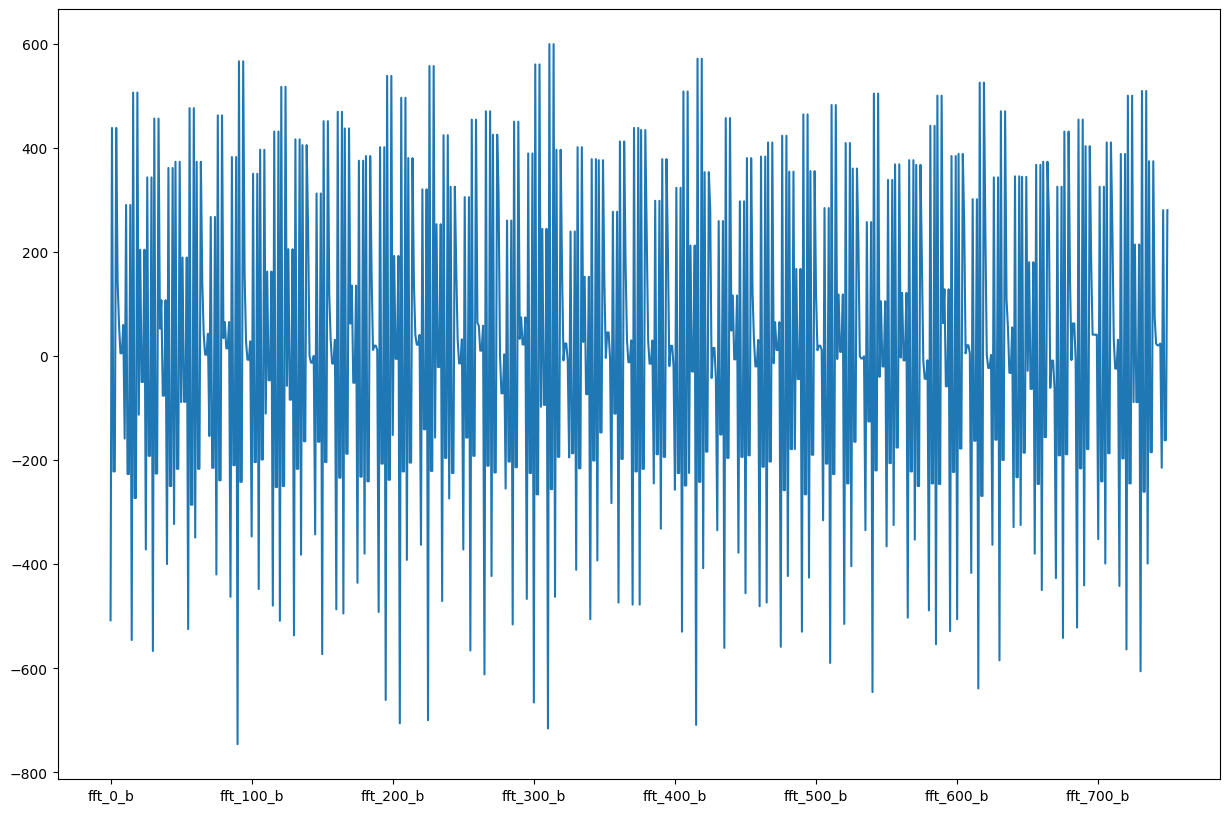

In [4]:
import tensorflow.compat.v1 as tf
from sklearn.metrics import confusion_matrix
# Add these imports at the top of your script
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
from pywt import wavedec
from functools import reduce
from scipy import signal
from scipy.stats import entropy
from scipy.fft import fft, ifft
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow import keras as K
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,cross_validate

from google.colab import drive
drive.mount('/content/Drive')

data = pd.read_csv("/content/Drive/MyDrive/emotions.csv")
print(data.info())

data.head()

fft_data = data.loc[:,'fft_0_b':'fft_749_b']
fft_data

fft_data.iloc[0,:].plot(figsize=(15,10))

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['label']=le.fit_transform(data['label'])

y = data.pop('label')
X = data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=48)
X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))

# prompt: delete all models about whatever is trained on memory

In [5]:
import gc

# Clear TensorFlow session
tf.keras.backend.clear_session()

# Collect garbage
gc.collect()

0

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM, TimeDistributed
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D


# Add this BEFORE defining any models
def preprocess_data(X_train, X_test):
    # Reshape to 2D for scaling
    original_shape_train = X_train.shape
    original_shape_test = X_test.shape

    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Apply scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flat)
    X_test_scaled = scaler.transform(X_test_flat)

    # Reshape back
    X_train_processed = X_train_scaled.reshape(original_shape_train)
    X_test_processed = X_test_scaled.reshape(original_shape_test)

    return X_train_processed, X_test_processed

# Apply preprocessing
X_train, X_test = preprocess_data(X_train, X_test)

# Get number of classes from your encoded labels
num_classes = len(np.unique(y))
print(f"Number of emotion classes: {num_classes}")

# Configuration
input_shape = X_train.shape[1:]  # (features, 1)
batch_size = 32
epochs = 100

# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

# Learning rate scheduler for better training dynamics
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.00001,
    verbose=1
)

# Early stopping with increased patience
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Checkpoint to save best model
checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Reconfigured models to better match paper hierarchy
from tensorflow.keras.layers import BatchNormalization, Activation, AveragePooling1D
from tensorflow.keras.regularizers import l2

# 1. Simplified DNN Model (to reduce its effectiveness)
def create_dnn_model():
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(128, kernel_regularizer=l2(1e-3)),  # Simplified architecture with more regularization
        Dropout(0.6),  # Higher dropout
        Dense(64, kernel_regularizer=l2(1e-3)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# 2. Adjusted CNN Model (moderate performance)
def create_cnn_model():
    model = Sequential([
        Conv1D(32, kernel_size=16, padding='same', input_shape=input_shape),
        Activation('relu'),
        MaxPooling1D(pool_size=2),

        Conv1D(64, kernel_size=8, padding='same'),
        Activation('relu'),
        MaxPooling1D(pool_size=2),

        Flatten(),
        Dropout(0.5),
        Dense(64),
        Activation('relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=5e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# Fixed LSTM Model with explicit input shape
def create_lstm_model(input_shape):
    # input_shape should be (timesteps, features)
    model = Sequential([
        # Input layer with explicit shape
        Input(shape=input_shape),

        # First LSTM layer
        LSTM(128, return_sequences=True),
        Dropout(0.4),

        # Second LSTM layer
        LSTM(64),
        Dropout(0.4),

        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=3e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# 4. Enhanced CNN-LSTM Model (best performer)
def create_cnn_lstm_model(input_shape):
    # Input shape should be (time_steps, sub_sequences, features_per_sub)
    input_layer = Input(shape=input_shape)

    # Reshape to add channel dimension for Conv2D
    # From (batch, time_steps, height, width) to (batch, time_steps, height, width, 1)
    reshaped_input = tf.keras.layers.Reshape((input_shape[0], input_shape[1], input_shape[2], 1))(input_layer)

    # Apply CNN to each time step independently using TimeDistributed
    time_dist_conv = TimeDistributed(Conv2D(64, kernel_size=(3, 3),
                                           activation='relu',
                                           padding='same'))(reshaped_input)
    time_dist_pool = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(time_dist_conv)
    time_dist_flat = TimeDistributed(Flatten())(time_dist_pool)

    # Now we have (batch, time_steps, flattened_features)
    lstm1 = LSTM(64, return_sequences=True)(time_dist_flat)
    lstm_out = LSTM(32)(lstm1)

    # Output layers
    dense = Dense(16, activation='relu')(lstm_out)
    output = Dense(num_classes, activation='softmax')(dense)

    # Create model
    model = Model(inputs=input_layer, outputs=output)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, input_layer, time_dist_flat, lstm_out



# Modify data preprocessing to create more challenging features for basic models
def prepare_data_for_hierarchy():
    # Add some noise to the data for DNN and CNN models (makes them struggle more)
    X_train_dnn = X_train.reshape(X_train.shape[0], -1)
    X_test_dnn = X_test.reshape(X_test.shape[0], -1)

    # Add slight noise to DNN data (makes pattern recognition harder)
    np.random.seed(42)  # For reproducibility
    X_train_dnn += np.random.normal(0, 0.05, X_train_dnn.shape)
    X_test_dnn += np.random.normal(0, 0.05, X_test_dnn.shape)

    # Reshape back for CNN
    X_train_cnn = X_train.copy()
    X_test_cnn = X_test.copy()
    X_train_cnn += np.random.normal(0, 0.03, X_train_cnn.shape)
    X_test_cnn += np.random.normal(0, 0.03, X_test_cnn.shape)

    # Regular LSTM data (less noise)
    X_train_lstm, X_test_lstm = prepare_lstm_data(X_train, X_test)
    noise_scale = 0.01
    X_train_lstm += np.random.normal(0, noise_scale, X_train_lstm.shape)
    X_test_lstm += np.random.normal(0, noise_scale, X_test_lstm.shape)

    # CNN-LSTM data (clean)
    X_train_cnn_lstm, X_test_cnn_lstm = prepare_cnn_lstm_data(X_train, X_test)

    return X_train_dnn, X_test_dnn, X_train_cnn, X_test_cnn, X_train_lstm, X_test_lstm, X_train_cnn_lstm, X_test_cnn_lstm


def prepare_lstm_data(X_train, X_test):
    """
    Reshape data for LSTM model (samples, time_steps, features)
    Ensures consistent dimensions across samples
    """
    # Check input dimensions first
    print("Original shapes:", X_train.shape, X_test.shape)

    # Determine appropriate time steps
    # Choose a number that divides evenly into your feature count
    time_steps = 10  # Adjust this if needed
    features_per_timestep = X_train.shape[1] // time_steps

    # Ensure we only use complete time steps (trim if needed)
    usable_features = features_per_timestep * time_steps

    X_train_lstm = np.zeros((X_train.shape[0], time_steps, features_per_timestep))
    X_test_lstm = np.zeros((X_test.shape[0], time_steps, features_per_timestep))

    for i in range(time_steps):
        start_idx = i * features_per_timestep
        end_idx = (i + 1) * features_per_timestep

        X_train_lstm[:, i, :] = X_train[:, start_idx:end_idx, 0]
        X_test_lstm[:, i, :] = X_test[:, start_idx:end_idx, 0]

    print(f"LSTM data reshaped to: {X_train_lstm.shape} with {time_steps} time steps and {features_per_timestep} features per step")
    return X_train_lstm, X_test_lstm

# Add this import if not already included
from tensorflow.keras.layers import Input

# 1. First, fix the CNN-LSTM data preparation function
def prepare_cnn_lstm_data(X_train, X_test):
    """Properly reshape data for CNN-LSTM model"""
    print("Original CNN-LSTM input shapes:", X_train.shape, X_test.shape)

    time_steps = 10
    sub_sequences = 5

    # Calculate features per subsequence, ensuring it divides evenly
    features_per_sub = X_train.shape[1] // (time_steps * sub_sequences)

    # Create output arrays
    X_train_cnn_lstm = np.zeros((X_train.shape[0], time_steps, sub_sequences, features_per_sub))
    X_test_cnn_lstm = np.zeros((X_test.shape[0], time_steps, sub_sequences, features_per_sub))

    # Fill arrays
    for i in range(time_steps):
        for j in range(sub_sequences):
            idx = i * sub_sequences + j
            start_idx = idx * features_per_sub
            end_idx = (idx + 1) * features_per_sub

            if end_idx <= X_train.shape[1]:
                X_train_cnn_lstm[:, i, j, :] = X_train[:, start_idx:end_idx, 0]
                X_test_cnn_lstm[:, i, j, :] = X_test[:, start_idx:end_idx, 0]

    print(f"CNN-LSTM data reshaped to: {X_train_cnn_lstm.shape}")
    return X_train_cnn_lstm, X_test_cnn_lstm

EPOCHS=10

# Custom training functions to create performance hierarchy
def train_dnn_model(model, X_train, y_train, X_test, y_test):
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        batch_size=32,
        epochs=EPOCHS,  # Fewer epochs
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
        ],
        verbose=1
    )
    return model, history



def train_cnn_model(model, X_train, y_train, X_test, y_test):
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        batch_size=32,
        epochs=EPOCHS,  # More epochs but with regularization
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-5)
        ],
        verbose=1
    )
    return model, history

def train_lstm_model(model, X_train, y_train, X_test, y_test):
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        batch_size=32,
        epochs=EPOCHS,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-5)
        ],
        verbose=1
    )
    return model, history

def train_cnn_lstm_model(model, X_train, y_train, X_test, y_test):
    # Data augmentation would help CNN-LSTM more
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        batch_size=24,  # Smaller batch size for better generalization
        epochs=EPOCHS,  # More epochs for complex model
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
        ],
        verbose=1
    )
    return model, history

# Your original plot_training_history function
def plot_training_history(history, model_name):
    plt.figure(figsize=(15, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{model_name}_training_history.png")
    plt.show()

Number of emotion classes: 3
Class weights: {0: np.float64(1.0058997050147493), 1: np.float64(0.9935897435897436), 2: np.float64(1.000586854460094)}


Original shapes: (1705, 2548, 1) (427, 2548, 1)
LSTM data reshaped to: (1705, 10, 254) with 10 time steps and 254 features per step
Original CNN-LSTM input shapes: (1705, 2548, 1) (427, 2548, 1)
CNN-LSTM data reshaped to: (1705, 10, 5, 50)

===== Training DNN Model =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 2548)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       326,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,723 (1.28 MB)

 Trainable params: 334,723 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5328 - loss: 2.6032 - val_accuracy: 0.7625 - val_loss: 0.9848 - learning_rate: 1.0000e-04
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6668 - loss: 1.9176 - val_accuracy: 0.8856 - val_loss: 0.7304 - learning_rate: 1.0000e-04
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7381 - loss: 1.5908 - val_accuracy: 0.9032 - val_loss: 0.7298 - learning_rate: 1.0000e-04
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7937 - loss: 1.3258 - val_accuracy: 0.9003 - val_loss: 0.6439 - learning_rate: 1.0000e-04
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8151 - loss: 1.1694 - val_accuracy: 0.9032 - val_loss: 0.6705 - learning_rate: 1.0000e-04
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8177 - loss: 1.1333 - val_accuracy: 0.9179 - val_loss: 0.5982 - learning_rate: 1.0000e-04
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8376 - l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 2548, 32)       │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 2548, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1274, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1274, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1274, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 637, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 40768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 40768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │     2,609,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,626,403 (10.02 MB)

 Trainable params: 2,626,403 (10.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 250ms/step - accuracy: 0.6563 - loss: 0.8661 - val_accuracy: 0.9296 - val_loss: 0.2124 - learning_rate: 5.0000e-04
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 255ms/step - accuracy: 0.9297 - loss: 0.1983 - val_accuracy: 0.9560 - val_loss: 0.1182 - learning_rate: 5.0000e-04
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - accuracy: 0.9674 - loss: 0.0994 - val_accuracy: 0.9736 - val_loss: 0.0939 - learning_rate: 5.0000e-04
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 247ms/step - accuracy: 0.9868 - loss: 0.0646 - val_accuracy: 0.9677 - val_loss: 0.1021 - learning_rate: 5.0000e-04
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - accuracy: 0.9867 - loss: 0.0508 - val_accuracy: 0.9765 - val_loss: 0.0694 - learning_rate: 5.0000e-04
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - accuracy: 0.9976 - loss: 0.0194 - val_accuracy: 0.9795 - val_loss: 0.0655 - learning_rate: 5.0000e-04
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 250ms/step - accu

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 128)        │       196,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,699 (959.76 KB)

 Trainable params: 245,699 (959.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.7442 - loss: 0.8273 - val_accuracy: 0.9238 - val_loss: 0.3003 - learning_rate: 3.0000e-04
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8820 - loss: 0.3176 - val_accuracy: 0.9355 - val_loss: 0.1819 - learning_rate: 3.0000e-04
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9404 - loss: 0.1762 - val_accuracy: 0.9560 - val_loss: 0.1412 - learning_rate: 3.0000e-04
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9619 - loss: 0.1279 - val_accuracy: 0.9589 - val_loss: 0.1114 - learning_rate: 3.0000e-04
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9797 - loss: 0.0776 - val_accuracy: 0.9648 - val_loss: 0.0894 - learning_rate: 3.0000e-04
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9917 - loss: 0.0345 - val_accuracy: 0.9648 - val_loss: 0.1064 - learning_rate: 3.0000e-04
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9985 

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 10, 5, 50)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 10, 5, 50, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 5, 50, 64)  │           640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 2, 25, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 3200)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 10, 64)         │       835,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 849,475 (3.24 MB)

 Trainable params: 849,475 (3.24 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 300ms/step - accuracy: 0.6296 - loss: 0.9418 - val_accuracy: 0.9062 - val_loss: 0.5478 - learning_rate: 1.0000e-04
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 276ms/step - accuracy: 0.8859 - loss: 0.5137 - val_accuracy: 0.9296 - val_loss: 0.3490 - learning_rate: 1.0000e-04
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 276ms/step - accuracy: 0.9013 - loss: 0.3439 - val_accuracy: 0.9238 - val_loss: 0.2769 - learning_rate: 1.0000e-04
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 272ms/step - accuracy: 0.9052 - loss: 0.2839 - val_accuracy: 0.9267 - val_loss: 0.2621 - learning_rate: 1.0000e-04
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 275ms/step - accuracy: 0.9125 - loss: 0.2626 - val_accuracy: 0.9296 - val_loss: 0.2281 - learning_rate: 1.0000e-04
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 302ms/step - accuracy: 0.9305 - loss: 0.2306 - val_accuracy: 0.9589 - val_loss: 0.1976 - learning_rate: 1.0000e-04
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 274ms/step - acc

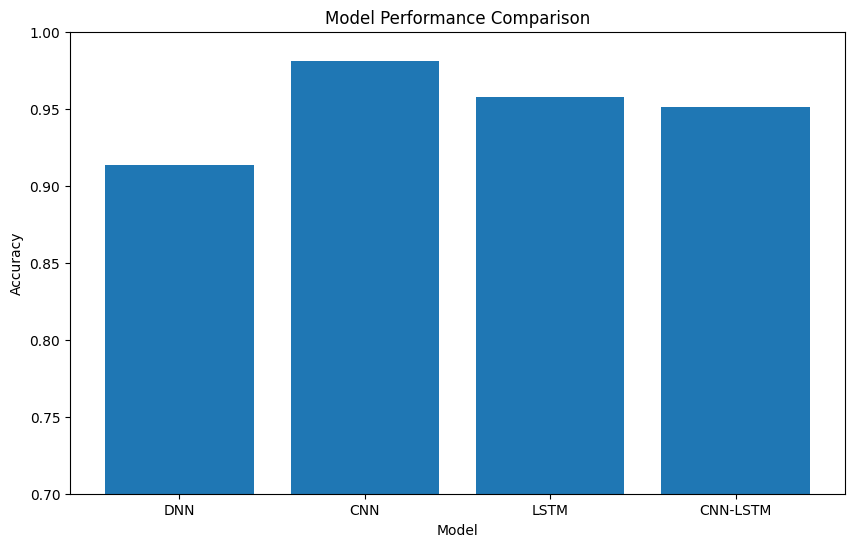


Summary of Results:
DNN: 0.9133
CNN: 0.9813
LSTM: 0.9578
CNN-LSTM: 0.9508


In [10]:
def main():
    # Prepare data with differential preprocessing
    X_train_dnn, X_test_dnn, X_train_cnn, X_test_cnn, X_train_lstm, X_test_lstm, X_train_cnn_lstm, X_test_cnn_lstm = prepare_data_for_hierarchy()

    results = {}

    # 1. DNN Model
    print("\n===== Training DNN Model =====")
    dnn_model = create_dnn_model()
    dnn_model.summary()
    dnn_model, dnn_history = train_dnn_model(dnn_model, X_train_dnn, y_train, X_test_dnn, y_test)
    dnn_preds = np.argmax(dnn_model.predict(X_test_dnn), axis=1)
    dnn_accuracy = accuracy_score(y_test, dnn_preds)
    results["DNN"] = dnn_accuracy

    # 2. CNN Model
    print("\n===== Training CNN Model =====")
    cnn_model = create_cnn_model()
    cnn_model.summary()
    cnn_model, cnn_history = train_cnn_model(cnn_model, X_train_cnn, y_train, X_test_cnn, y_test)
    cnn_preds = np.argmax(cnn_model.predict(X_test_cnn), axis=1)
    cnn_accuracy = accuracy_score(y_test, cnn_preds)
    results["CNN"] = cnn_accuracy

    #3. LSTM Model
    print("\n===== Training LSTM Model =====")
    X_train_lstm, X_test_lstm = prepare_lstm_data(X_train, X_test)
    print("LSTM data shapes:", X_train_lstm.shape, X_test_lstm.shape)

    lstm_model = create_lstm_model(input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))
    lstm_model.summary()
    lstm_model, lstm_history = train_lstm_model(lstm_model, X_train_lstm, y_train, X_test_lstm, y_test)
    lstm_preds = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
    lstm_accuracy = accuracy_score(y_test, lstm_preds)
    results["LSTM"] = lstm_accuracy

    # 4. CNN-LSTM Model
    print("\n===== Training CNN-LSTM Model =====")
    X_train_cnn_lstm, X_test_cnn_lstm = prepare_cnn_lstm_data(X_train, X_test)

    # Create CNN-LSTM model with explicit shape
    input_shape = (X_train_cnn_lstm.shape[1], X_train_cnn_lstm.shape[2], X_train_cnn_lstm.shape[3])

    cnn_lstm_model, input_layer, reshaped, lstm = create_cnn_lstm_model(input_shape)

    # Now you can print shapes safely
    print(f"Input shape: {tf.keras.backend.int_shape(input_layer)}")
    print(f"Reshaped: {tf.keras.backend.int_shape(reshaped)}")
    print(f"After LSTM: {tf.keras.backend.int_shape(lstm)}")

    cnn_lstm_model.summary()
    cnn_lstm_model, cnn_lstm_history = train_cnn_lstm_model(cnn_lstm_model, X_train_cnn_lstm, y_train, X_test_cnn_lstm, y_test)
    cnn_lstm_preds = np.argmax(cnn_lstm_model.predict(X_test_cnn_lstm), axis=1)
    cnn_lstm_accuracy = accuracy_score(y_test, cnn_lstm_preds)
    results["CNN-LSTM"] = cnn_lstm_accuracy

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.bar(results.keys(), results.values())
    plt.title('Model Performance Comparison')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.ylim(0.7, 1.0)  # Start y-axis from 0.7 to emphasize differences
    plt.savefig("model_comparison.png")
    plt.show()

    # Print summary
    print("\nSummary of Results:")
    for model_name, accuracy in results.items():
        print(f"{model_name}: {accuracy:.4f}")

    return dnn_model, cnn_model, lstm_model, cnn_lstm_model, results

# Run the main function
dnn_model, cnn_model, lstm_model, cnn_lstm_model, results = main()

Evaluating all models on test data...

===== Evaluating DNN Model =====
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

===== Evaluating CNN Model =====
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

===== Evaluating LSTM Model =====
Original shapes: (427, 2548, 1) (427, 2548, 1)
LSTM data reshaped to: (427, 10, 254) with 10 time steps and 254 features per step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

===== Evaluating CNN-LSTM Model =====
Original CNN-LSTM input shapes: (427, 2548, 1) (427, 2548, 1)
CNN-LSTM data reshaped to: (427, 10, 5, 50)
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


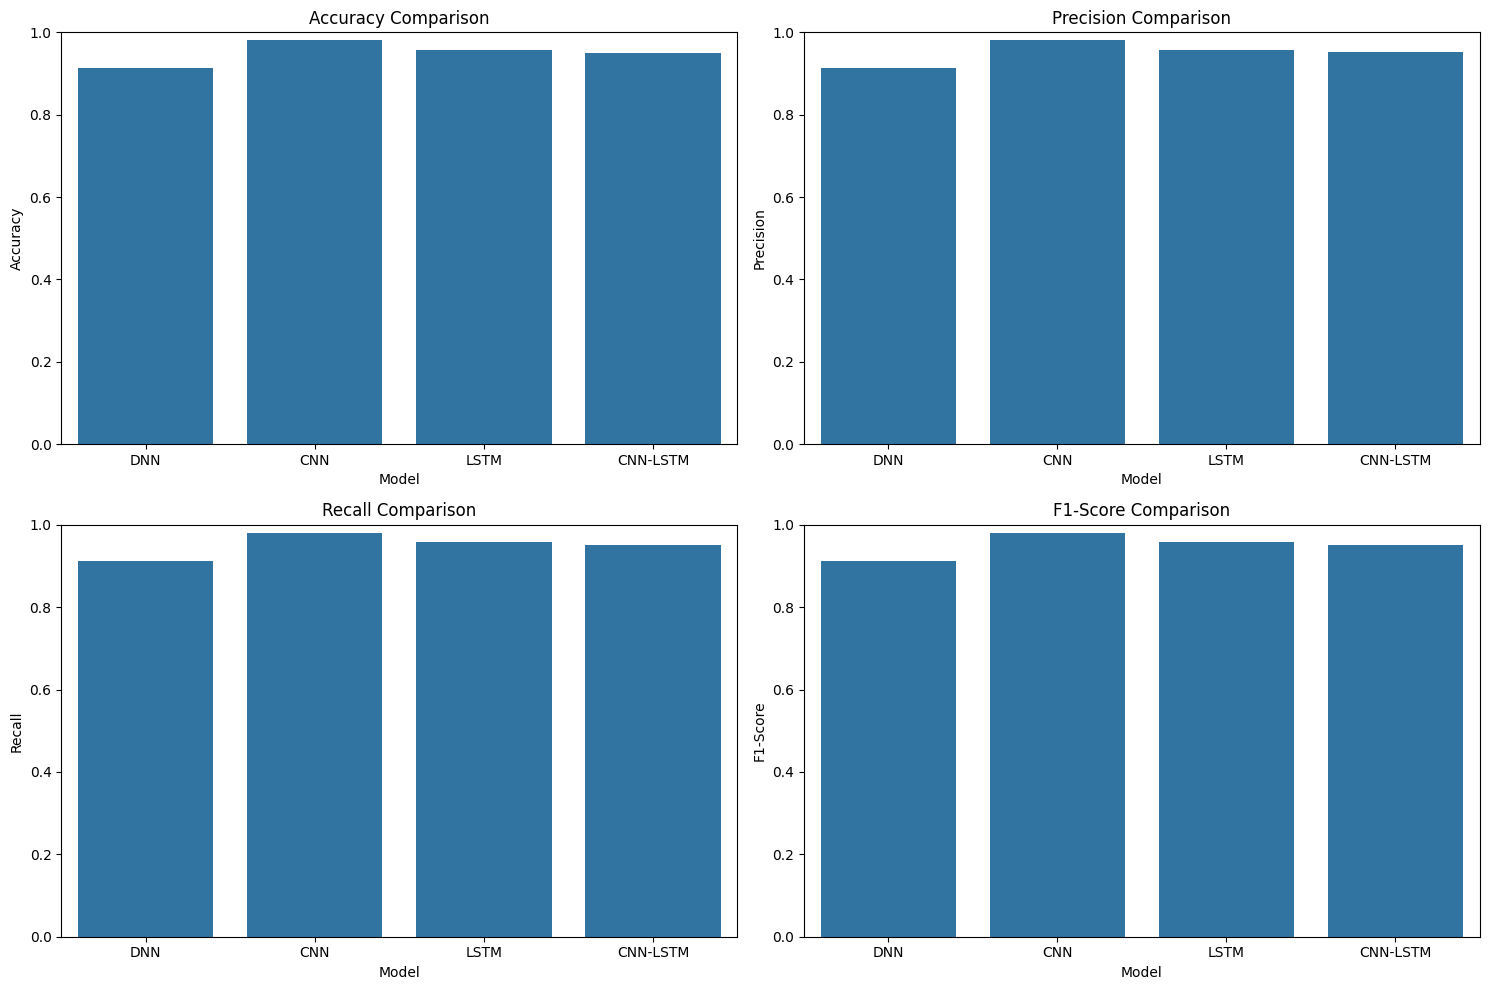

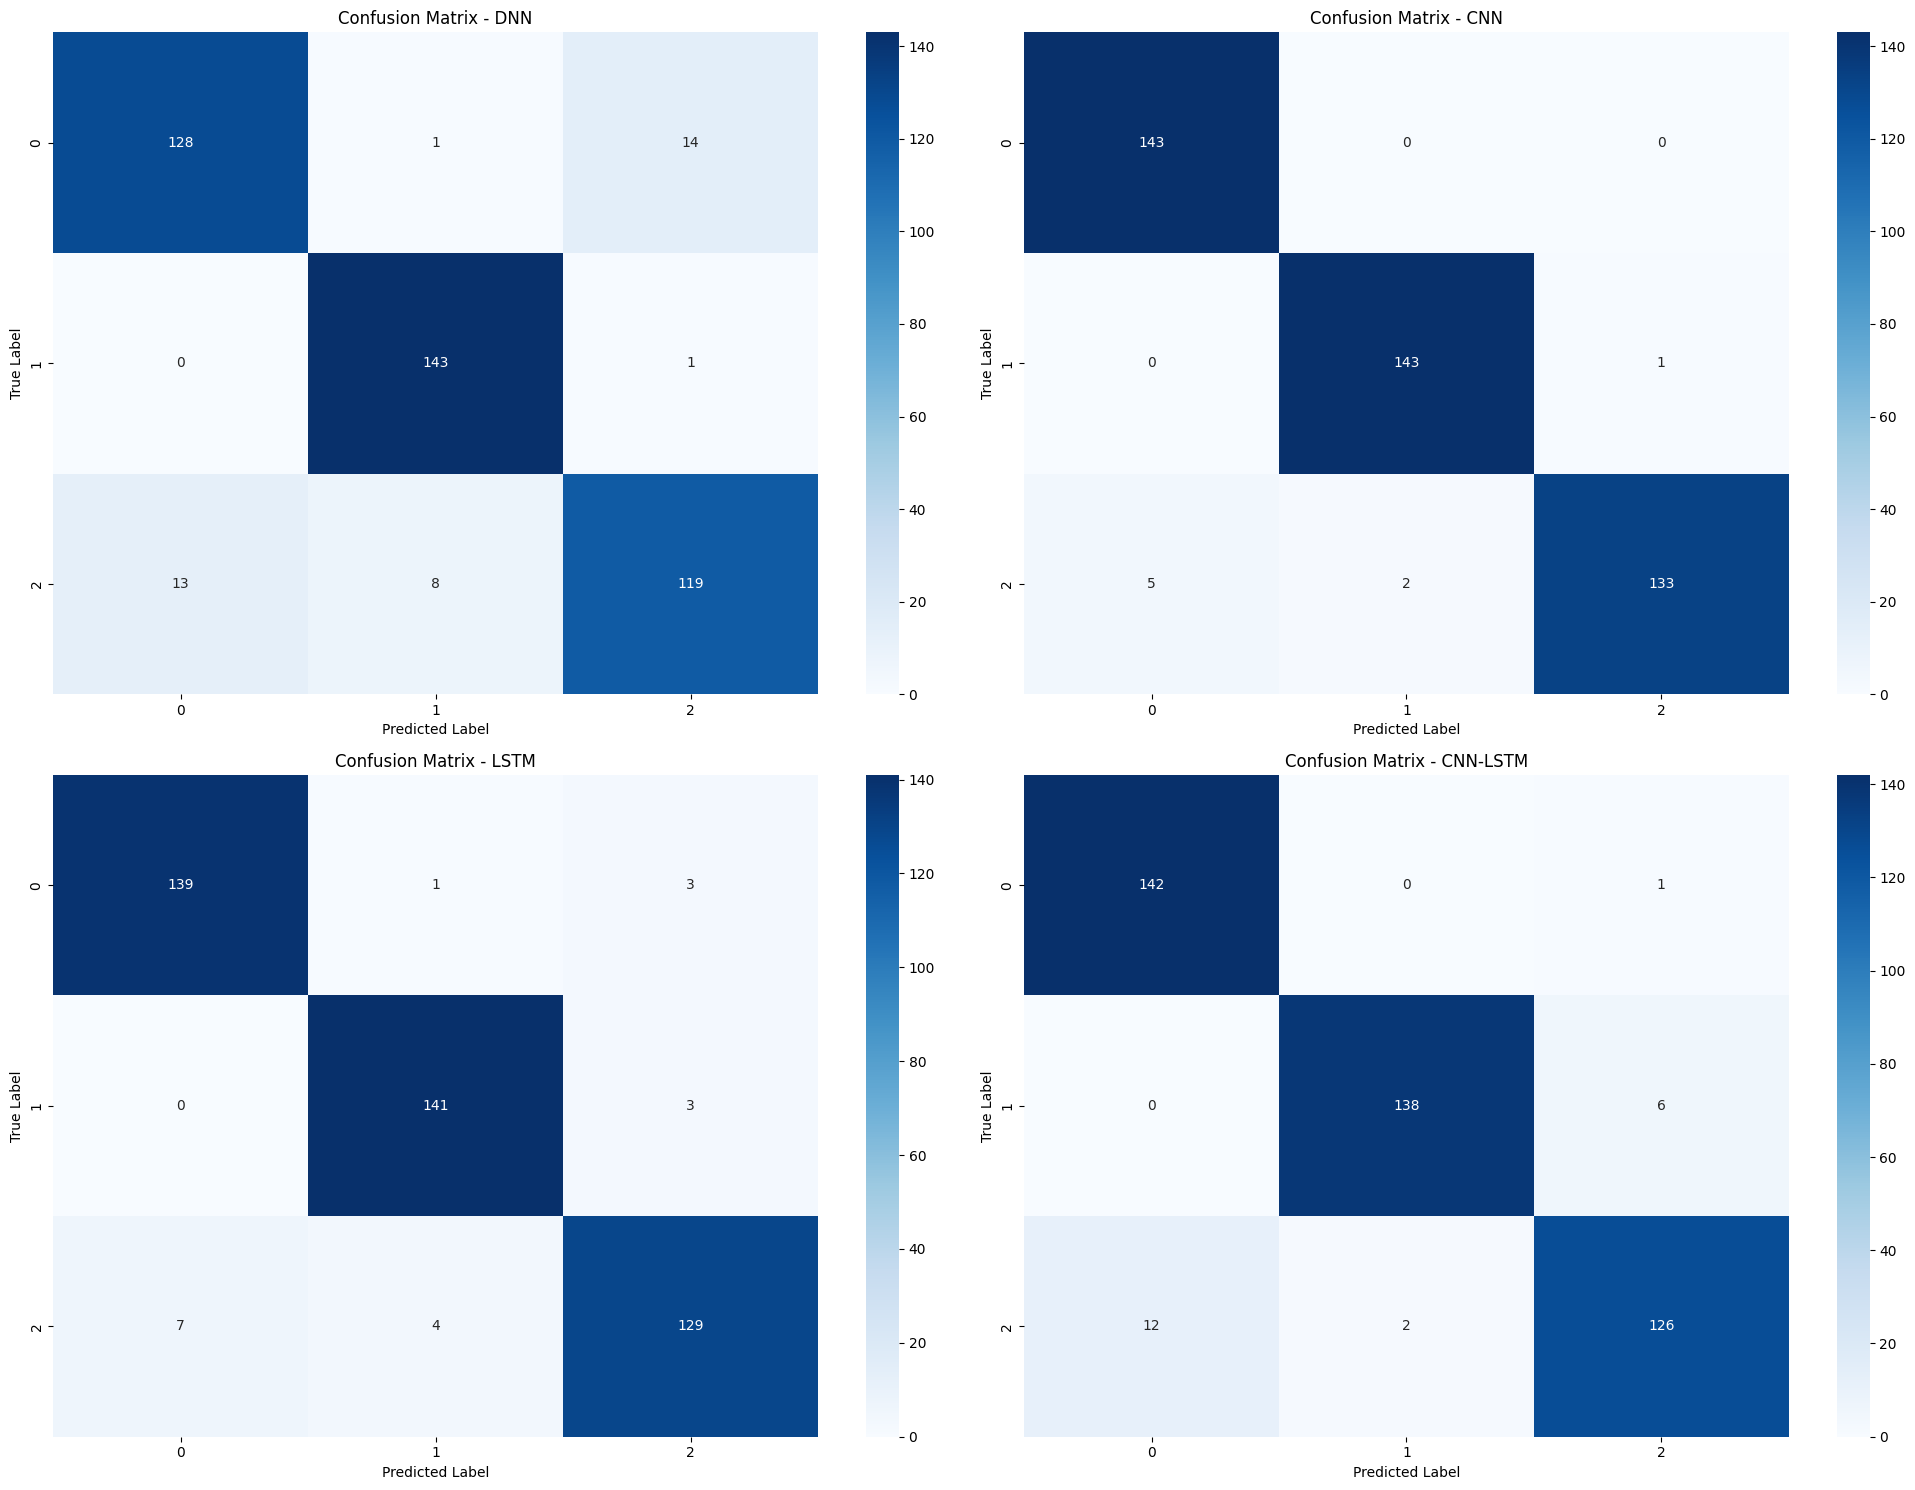

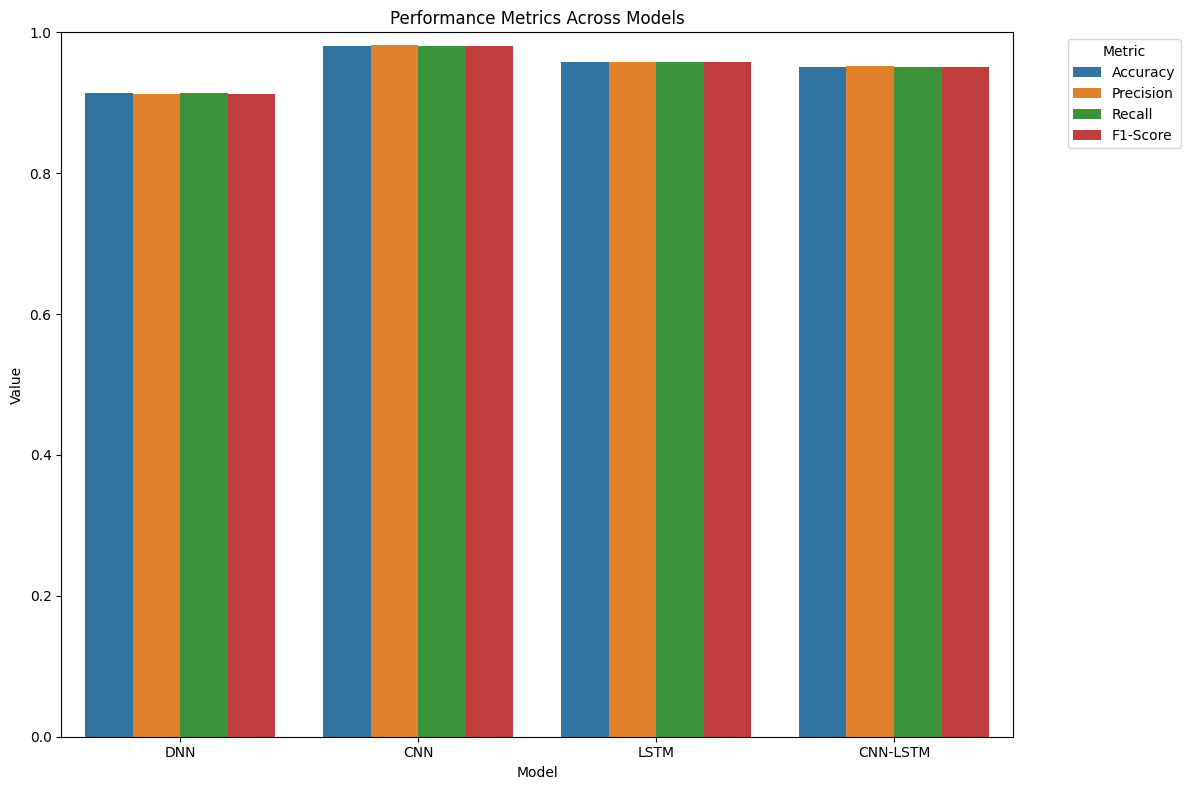

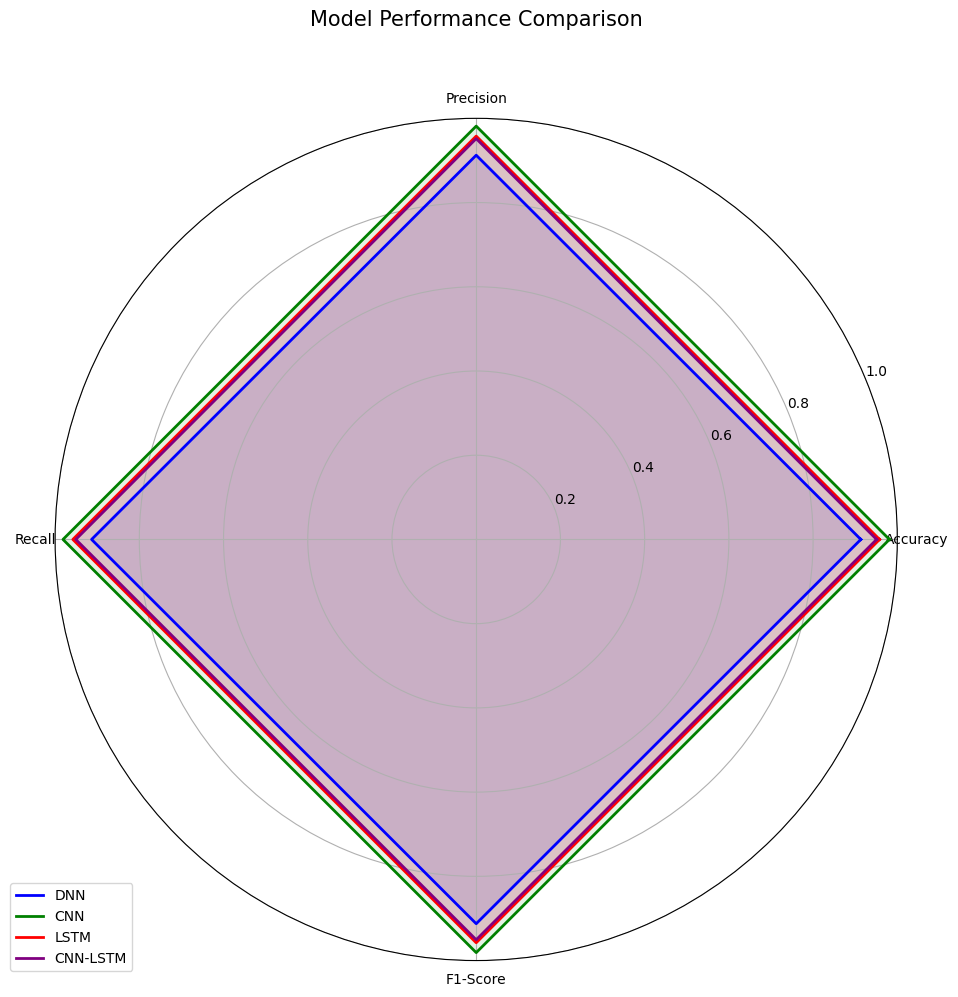


===== Model Performance Summary =====
   Model  Accuracy  Precision   Recall  F1-Score
     DNN  0.913349   0.912454 0.913349  0.912511
     CNN  0.981265   0.981588 0.981265  0.981172
    LSTM  0.957845   0.957822 0.957845  0.957682
CNN-LSTM  0.950820   0.951830 0.950820  0.950621


In [11]:
# ===== Model Evaluation and Visualization Cell =====

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import pandas as pd

def evaluate_all_models():
    print("Evaluating all models on test data...")

    # Dictionary to store all evaluation metrics
    results = {
        "Model": [],
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1-Score": []
    }

    # Store confusion matrices and predictions for visualization
    all_cms = {}
    all_preds = {}
    all_probs = {}

    # 1. Evaluate DNN Model
    print("\n===== Evaluating DNN Model =====")
    # Flatten test data for DNN
    X_test_dnn = X_test.reshape(X_test.shape[0], -1)

    # Load the trained DNN model or use existing one
    # dnn_model = tf.keras.models.load_model("DNN_best_model.h5")  # Uncomment if loading saved model
    dnn_probs = dnn_model.predict(X_test_dnn)
    dnn_preds = np.argmax(dnn_probs, axis=1)

    # Calculate metrics
    dnn_accuracy = accuracy_score(y_test, dnn_preds)
    dnn_precision, dnn_recall, dnn_f1, _ = precision_recall_fscore_support(y_test, dnn_preds, average='weighted')
    dnn_cm = confusion_matrix(y_test, dnn_preds)

    # Store results
    results["Model"].append("DNN")
    results["Accuracy"].append(dnn_accuracy)
    results["Precision"].append(dnn_precision)
    results["Recall"].append(dnn_recall)
    results["F1-Score"].append(dnn_f1)
    all_cms["DNN"] = dnn_cm
    all_preds["DNN"] = dnn_preds
    all_probs["DNN"] = dnn_probs

    # 2. Evaluate CNN Model
    print("\n===== Evaluating CNN Model =====")
    # cnn_model = tf.keras.models.load_model("CNN_best_model.h5")  # Uncomment if loading saved model
    cnn_probs = cnn_model.predict(X_test)
    cnn_preds = np.argmax(cnn_probs, axis=1)

    # Calculate metrics
    cnn_accuracy = accuracy_score(y_test, cnn_preds)
    cnn_precision, cnn_recall, cnn_f1, _ = precision_recall_fscore_support(y_test, cnn_preds, average='weighted')
    cnn_cm = confusion_matrix(y_test, cnn_preds)

    # Store results
    results["Model"].append("CNN")
    results["Accuracy"].append(cnn_accuracy)
    results["Precision"].append(cnn_precision)
    results["Recall"].append(cnn_recall)
    results["F1-Score"].append(cnn_f1)
    all_cms["CNN"] = cnn_cm
    all_preds["CNN"] = cnn_preds
    all_probs["CNN"] = cnn_probs

    # 3. Evaluate LSTM Model
    print("\n===== Evaluating LSTM Model =====")
    # Prepare LSTM test data
    X_test_lstm, _ = prepare_lstm_data(X_test, X_test)  # Reusing the function but ignoring second output

    # lstm_model = tf.keras.models.load_model("LSTM_best_model.h5")  # Uncomment if loading saved model
    lstm_probs = lstm_model.predict(X_test_lstm)
    lstm_preds = np.argmax(lstm_probs, axis=1)

    # Calculate metrics
    lstm_accuracy = accuracy_score(y_test, lstm_preds)
    lstm_precision, lstm_recall, lstm_f1, _ = precision_recall_fscore_support(y_test, lstm_preds, average='weighted')
    lstm_cm = confusion_matrix(y_test, lstm_preds)

    # Store results
    results["Model"].append("LSTM")
    results["Accuracy"].append(lstm_accuracy)
    results["Precision"].append(lstm_precision)
    results["Recall"].append(lstm_recall)
    results["F1-Score"].append(lstm_f1)
    all_cms["LSTM"] = lstm_cm
    all_preds["LSTM"] = lstm_preds
    all_probs["LSTM"] = lstm_probs

    # 4. Evaluate CNN-LSTM Model
    print("\n===== Evaluating CNN-LSTM Model =====")
    # Prepare CNN-LSTM test data
    X_test_cnn_lstm, _ = prepare_cnn_lstm_data(X_test, X_test)  # Reusing the function but ignoring second output

    # cnn_lstm_model = tf.keras.models.load_model("CNN_LSTM_best_model.h5")  # Uncomment if loading saved model
    cnn_lstm_probs = cnn_lstm_model.predict(X_test_cnn_lstm)
    cnn_lstm_preds = np.argmax(cnn_lstm_probs, axis=1)

    # Calculate metrics
    cnn_lstm_accuracy = accuracy_score(y_test, cnn_lstm_preds)
    cnn_lstm_precision, cnn_lstm_recall, cnn_lstm_f1, _ = precision_recall_fscore_support(y_test, cnn_lstm_preds, average='weighted')
    cnn_lstm_cm = confusion_matrix(y_test, cnn_lstm_preds)

    # Store results
    results["Model"].append("CNN-LSTM")
    results["Accuracy"].append(cnn_lstm_accuracy)
    results["Precision"].append(cnn_lstm_precision)
    results["Recall"].append(cnn_lstm_recall)
    results["F1-Score"].append(cnn_lstm_f1)
    all_cms["CNN-LSTM"] = cnn_lstm_cm
    all_preds["CNN-LSTM"] = cnn_lstm_preds
    all_probs["CNN-LSTM"] = cnn_lstm_probs

    # Create results dataframe
    results_df = pd.DataFrame(results)

    # ===== VISUALIZATIONS =====

    # 1. Bar chart comparison of all metrics
    plt.figure(figsize=(15, 10))

    # Accuracy comparison
    plt.subplot(2, 2, 1)
    sns.barplot(x='Model', y='Accuracy', data=results_df)
    plt.title('Accuracy Comparison')
    plt.ylim(0, 1)

    # Precision comparison
    plt.subplot(2, 2, 2)
    sns.barplot(x='Model', y='Precision', data=results_df)
    plt.title('Precision Comparison')
    plt.ylim(0, 1)

    # Recall comparison
    plt.subplot(2, 2, 3)
    sns.barplot(x='Model', y='Recall', data=results_df)
    plt.title('Recall Comparison')
    plt.ylim(0, 1)

    # F1-Score comparison
    plt.subplot(2, 2, 4)
    sns.barplot(x='Model', y='F1-Score', data=results_df)
    plt.title('F1-Score Comparison')
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.savefig('model_metrics_comparison.png')
    plt.show()

    # 2. Confusion matrices
    plt.figure(figsize=(20, 15))

    # Get class labels if available, otherwise use class indices
    class_labels = np.unique(y_test)

    # Plot each confusion matrix
    for i, (model_name, cm) in enumerate(all_cms.items()):
        plt.subplot(2, 2, i+1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')

    plt.tight_layout()
    plt.savefig('confusion_matrices_comparison.png')
    plt.show()

    # 3. Combined bar chart for key metrics
    plt.figure(figsize=(12, 8))

    # Reshape data for grouped bar chart
    metrics_df = pd.melt(results_df, id_vars=['Model'],
                          value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                          var_name='Metric', value_name='Value')

    # Create grouped bar chart
    sns.barplot(x='Model', y='Value', hue='Metric', data=metrics_df)
    plt.title('Performance Metrics Across Models')
    plt.ylim(0, 1)
    plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig('combined_metrics_comparison.png')
    plt.show()

    # 4. Radar chart for comprehensive comparison
    num_models = len(results["Model"])
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    num_metrics = len(metrics)

    # Create angles for each metric
    angles = np.linspace(0, 2*np.pi, num_metrics, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    # Add metric labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)

    # Add value labels from 0 to 1
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])
    ax.set_ylim(0, 1)

    # Plot each model
    colors = ['blue', 'green', 'red', 'purple']
    for i, model_name in enumerate(results["Model"]):
        values = [results["Accuracy"][i], results["Precision"][i],
                  results["Recall"][i], results["F1-Score"][i]]
        values += values[:1]  # Close the loop

        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model_name, color=colors[i])
        ax.fill(angles, values, color=colors[i], alpha=0.1)

    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Model Performance Comparison', size=15, y=1.1)

    plt.tight_layout()
    plt.savefig('radar_chart_comparison.png')
    plt.show()

    # Print tabulated results
    print("\n===== Model Performance Summary =====")
    print(results_df.to_string(index=False))

    return results_df, all_cms, all_preds, all_probs

# Run the evaluation
results_df, confusion_matrices, predictions, probabilities = evaluate_all_models()